# K-Means for Hearing Threshold Data Clustering - Slope transformation

`Each participant's both ears are treated as if they were two participants.`

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

import seaborn as sns
import numpy as np

In [2]:
# Load the data
file_path = "../../data/nhanes_1520_age.csv"
data = pd.read_csv(file_path)
data.set_index('SEQN', inplace=True)
print(data.shape)
data.head()

(9729, 15)


,AUXU500R,AUXU1K1R,AUXU2KR,AUXU3KR,AUXU4KR,AUXU6KR,AUXU8KR,AUXU500L,AUXU1K1L,AUXU2KL,AUXU3KL,AUXU4KL,AUXU6KL,AUXU8KL,RIDAGEYR
SEQN,,,,,,,,,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0,5.0,5.0,5.0,35.0,50.0,50.0,55.0,62
83733,10.0,15.0,40.0,55.0,60.0,55.0,65.0,5.0,20.0,50.0,55.0,60.0,55.0,60.0,53
83735,25.0,25.0,30.0,20.0,40.0,40.0,55.0,15.0,25.0,30.0,30.0,45.0,60.0,50.0,56
83736,10.0,10.0,10.0,15.0,10.0,15.0,20.0,15.0,10.0,15.0,25.0,15.0,25.0,20.0,42
83741,5.0,0.0,5.0,5.0,5.0,20.0,15.0,0.0,-5.0,0.0,5.0,-5.0,10.0,10.0,22


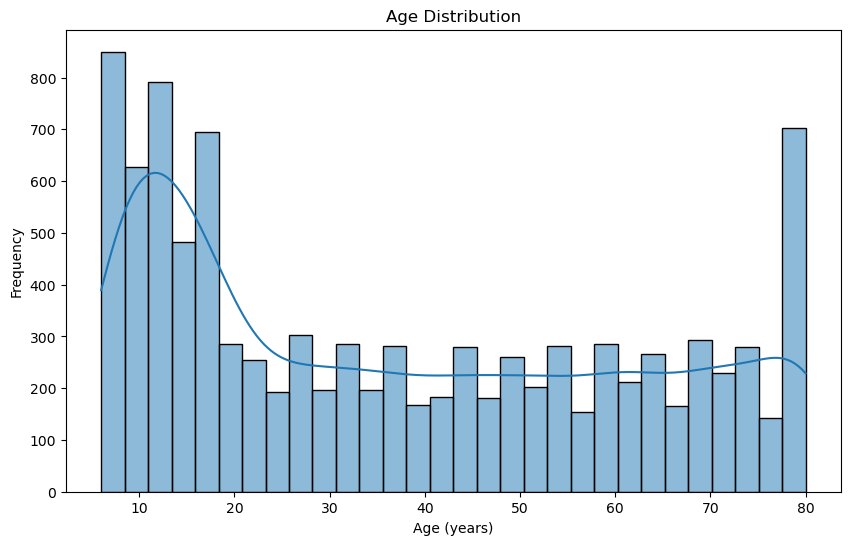

In [3]:
# Check the age distribution in the column 'RIDAGEYR'
plt.figure(figsize=(10, 6))
sns.histplot(data['RIDAGEYR'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

In [4]:
# Select the columns for right ear measurements

right_ear_columns = ['AUXU500R', 'AUXU1K1R', 'AUXU2KR', 'AUXU3KR', 'AUXU4KR', 'AUXU6KR', 'AUXU8KR']
right_ear_data = data[right_ear_columns]
right_ear_data.columns = ['500 Hz', '1 kHz', '2 kHz', '3 kHz', '4 kHz', '6 kHz', '8 kHz']

# Select the columns for left ear measurements

left_ear_columns = ['AUXU500L', 'AUXU1K1L', 'AUXU2KL', 'AUXU3KL', 'AUXU4KL', 'AUXU6KL', 'AUXU8KL']
left_ear_data = data[left_ear_columns]
left_ear_data.columns = ['500 Hz', '1 kHz', '2 kHz', '3 kHz', '4 kHz', '6 kHz', '8 kHz']

# Concatenate the right and left ear data

ear_data = pd.concat([right_ear_data, left_ear_data], axis=0)

# Change the column names to be more descriptive

ear_data

,500 Hz,1 kHz,2 kHz,3 kHz,4 kHz,6 kHz,8 kHz
SEQN,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0
83733,10.0,15.0,40.0,55.0,60.0,55.0,65.0
83735,25.0,25.0,30.0,20.0,40.0,40.0,55.0
83736,10.0,10.0,10.0,15.0,10.0,15.0,20.0
83741,5.0,0.0,5.0,5.0,5.0,20.0,15.0
...,...,...,...,...,...,...,...
124797,888.0,0.0,-5.0,888.0,5.0,888.0,10.0
124799,20.0,40.0,45.0,45.0,60.0,85.0,666.0
124811,35.0,30.0,15.0,30.0,25.0,55.0,60.0


In [32]:
# Process missing values
cleaned_ear_data = ear_data.replace({888: np.nan, 666: np.nan, '.': np.nan}, inplace=False)
cleaned_ear_data = cleaned_ear_data.dropna(inplace=False)
# cleaned_ear_data.reset_index(drop=True, inplace=True)

cleaned_ear_data

,500 Hz,1 kHz,2 kHz,3 kHz,4 kHz,6 kHz,8 kHz
SEQN,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0
83733,10.0,15.0,40.0,55.0,60.0,55.0,65.0
83735,25.0,25.0,30.0,20.0,40.0,40.0,55.0
83736,10.0,10.0,10.0,15.0,10.0,15.0,20.0
83741,5.0,0.0,5.0,5.0,5.0,20.0,15.0
...,...,...,...,...,...,...,...
124784,45.0,50.0,50.0,50.0,50.0,45.0,80.0
124786,0.0,10.0,10.0,5.0,0.0,15.0,0.0
124787,20.0,10.0,5.0,5.0,5.0,10.0,5.0


In [47]:
# Define frequencies and their differences
frequencies = ['500 Hz', '1 kHz', '2 kHz', '3 kHz', '4 kHz', '6 kHz', '8 kHz']
freq_differences = [500, 1000, 1000, 1000, 2000, 2000]  # Differences between frequencies
local_slope_data = cleaned_ear_data.copy()
global_slope_data = cleaned_ear_data.copy()

# Compute the subsequent columns
for i in range(1, len(frequencies)):
    local_slope_data[frequencies[i]] = (cleaned_ear_data[frequencies[i]] - cleaned_ear_data[frequencies[i - 1]]) / freq_differences[i - 1]
    global_slope_data[frequencies[i]] = (cleaned_ear_data[frequencies[i]] - cleaned_ear_data[frequencies[0]]) / sum(freq_differences[:i])

In [48]:
local_slope_data

,500 Hz,1 kHz,2 kHz,3 kHz,4 kHz,6 kHz,8 kHz
SEQN,,,,,,,
83732,10.0,-0.01,0.000,0.015,0.010,-0.0025,0.0125
83733,10.0,0.01,0.025,0.015,0.005,-0.0025,0.0050
83735,25.0,0.00,0.005,-0.010,0.020,0.0000,0.0075
83736,10.0,0.00,0.000,0.005,-0.005,0.0025,0.0025
83741,5.0,-0.01,0.005,0.000,0.000,0.0075,-0.0025
...,...,...,...,...,...,...,...
124784,45.0,0.01,0.000,0.000,0.000,-0.0025,0.0175
124786,0.0,0.02,0.000,-0.005,-0.005,0.0075,-0.0075
124787,20.0,-0.02,-0.005,0.000,0.000,0.0025,-0.0025


In [58]:
global_slope_data['500 Hz']

SEQN
83732     10.0
83733     10.0
83735     25.0
83736     10.0
83741      5.0
          ... 
124784    45.0
124786     0.0
124787    20.0
124811    35.0
124822     5.0
Name: 500 Hz, Length: 16510, dtype: float64

In [ ]:
global_slope_data['500 Hz'] = StandardScaler().fit_transform(global_slope_data['500 Hz'].values.reshape(-1, 1))
global_slope_data

# K-Means with local slope data

KMeans with 2 clusters
Silhouette Score: 0.257
Davies Bouldin Score: 1.622
Calinski Harabasz Score: 4647.170
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.068
Davies Bouldin Score: 1.874
Calinski Harabasz Score: 3418.526
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.042
Davies Bouldin Score: 1.942
Calinski Harabasz Score: 2529.259
--------------------------------------------------


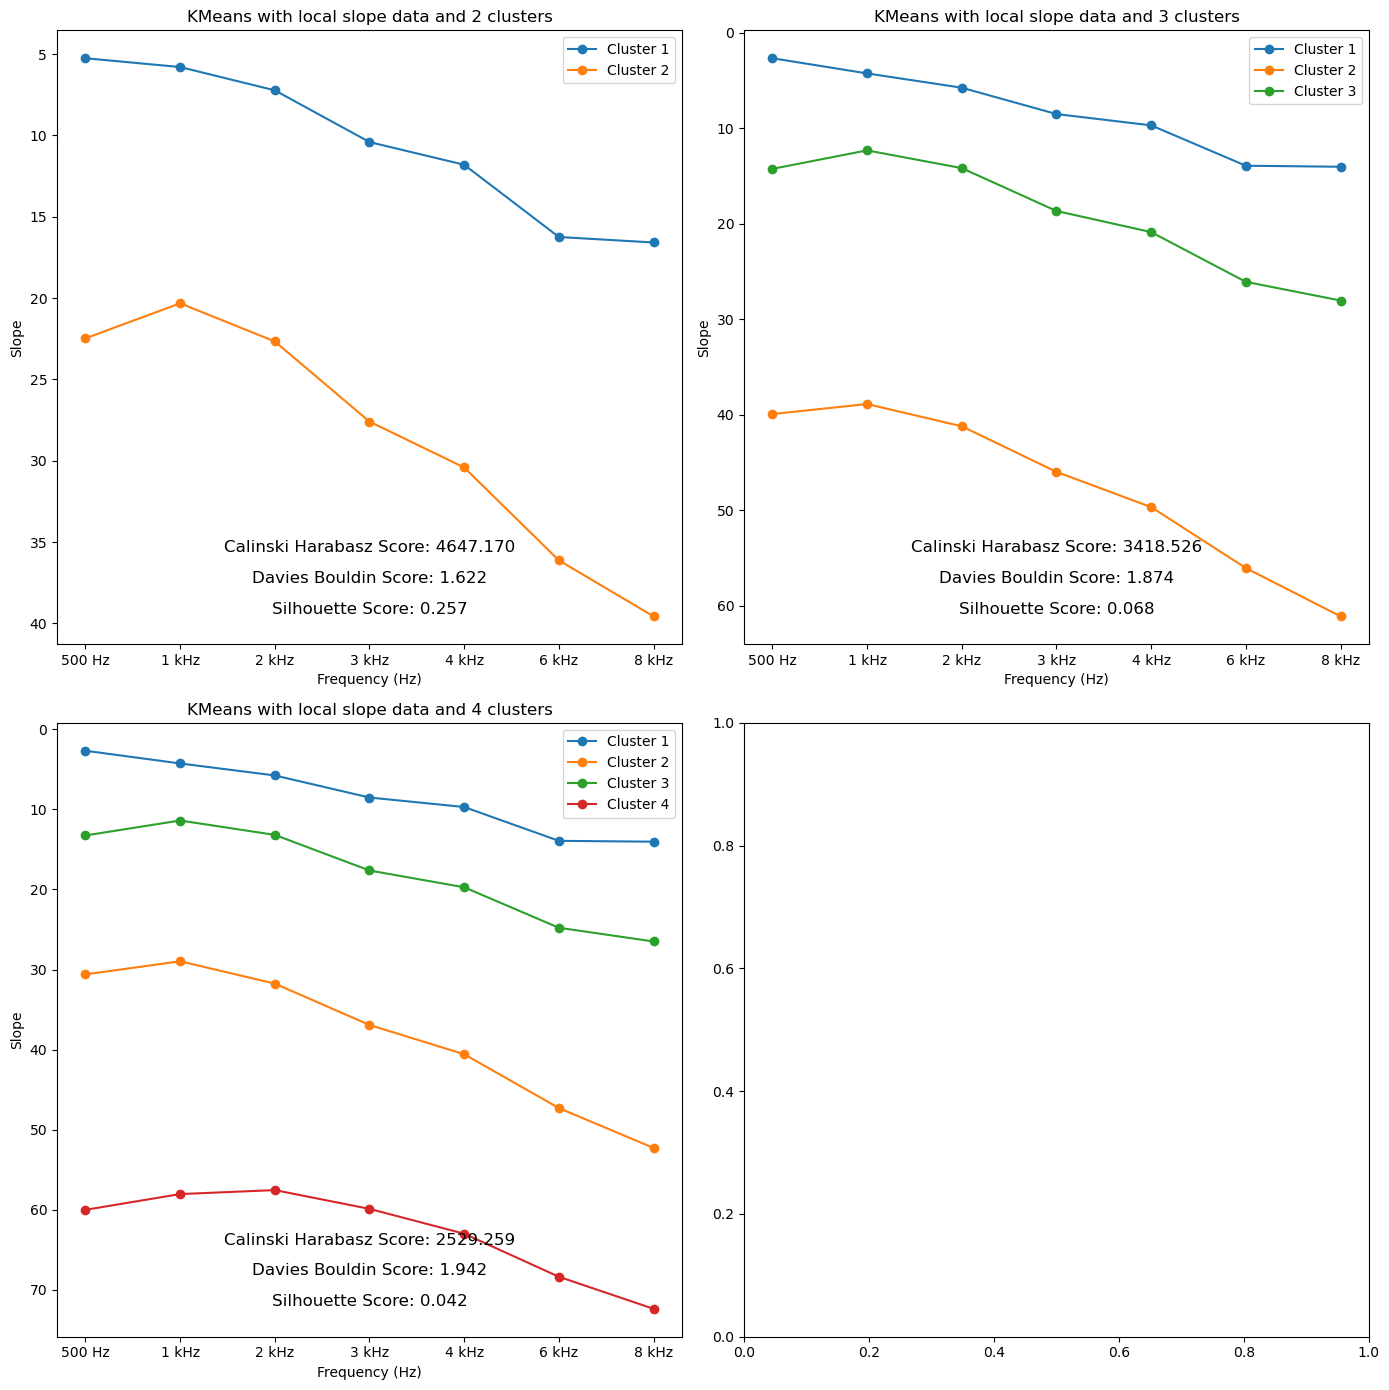

In [53]:
# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(local_slope_data)

    # Calculate the actual centroids using the raw data
    centroids = cleaned_ear_data.groupby(kmeans.labels_).mean()
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with local slope data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Slope')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

# K-Means with global slope data

KMeans with 2 clusters
Silhouette Score: 0.257
Davies Bouldin Score: 1.622
Calinski Harabasz Score: 4647.170
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.068
Davies Bouldin Score: 1.874
Calinski Harabasz Score: 3418.526
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.041
Davies Bouldin Score: 1.997
Calinski Harabasz Score: 2570.931
--------------------------------------------------


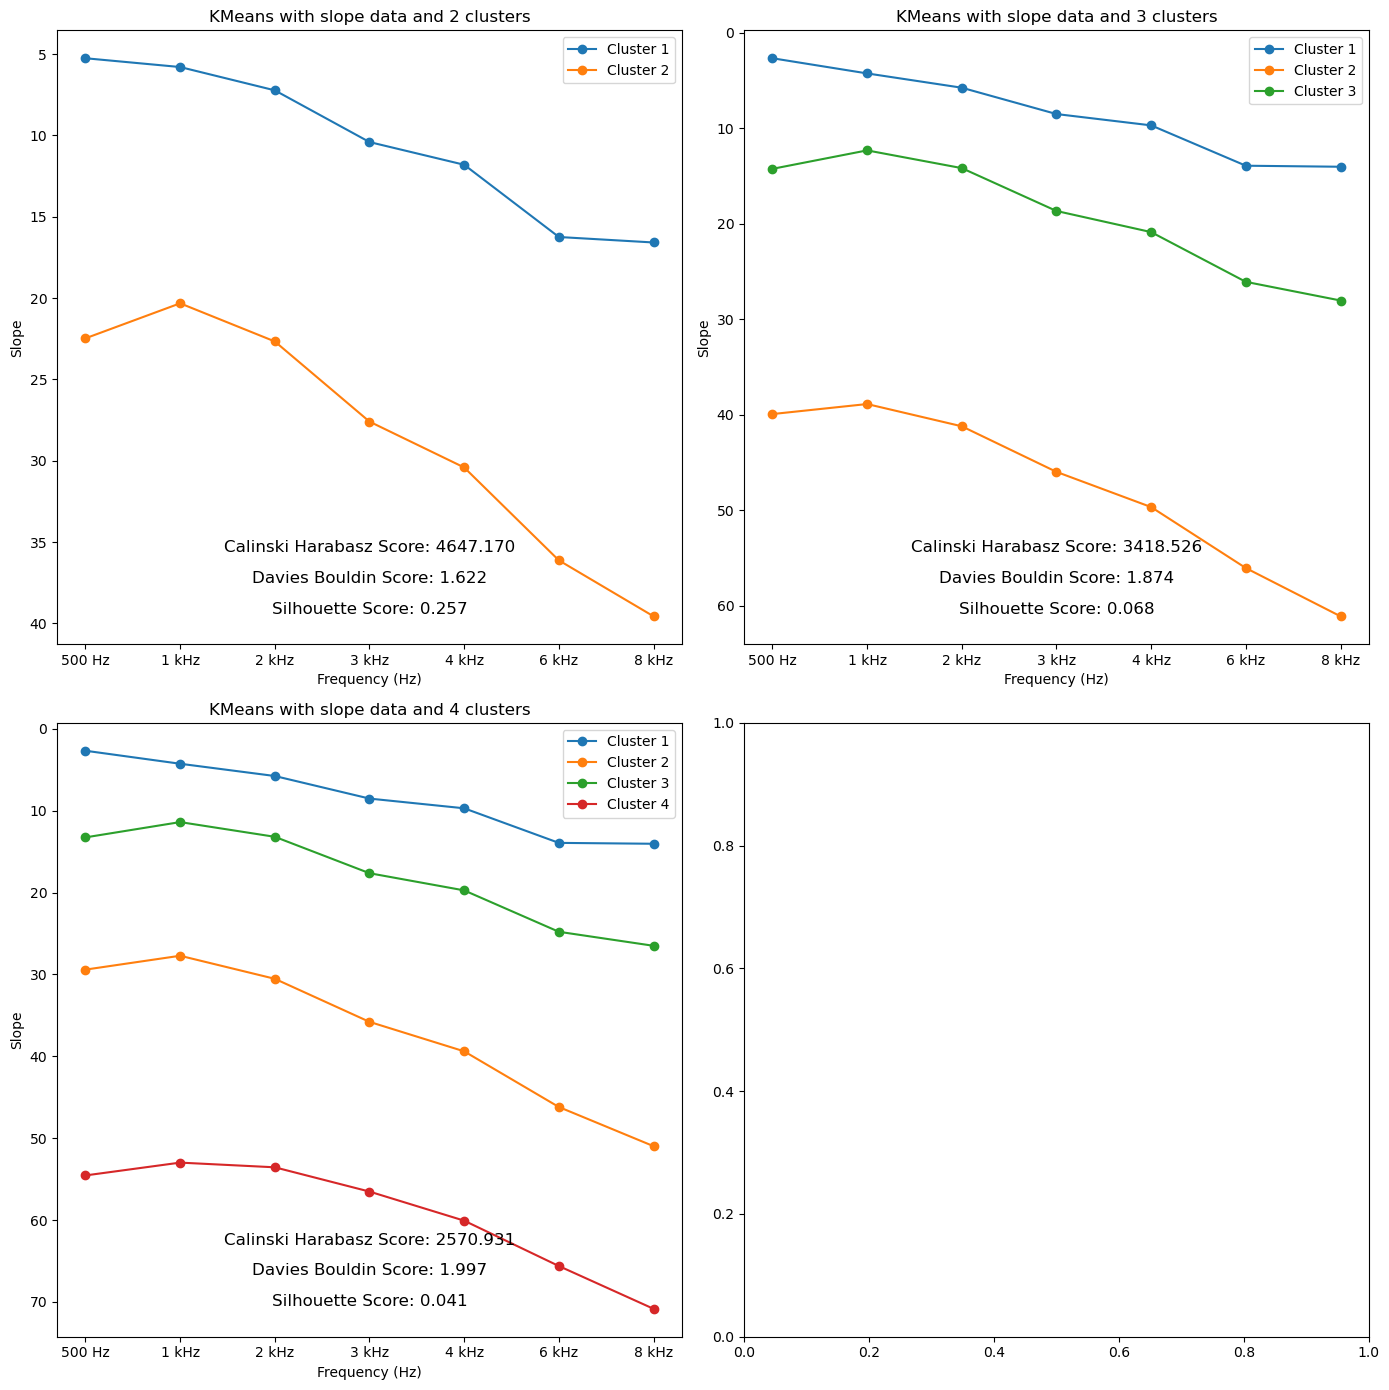

In [ ]:
# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(global_slope_data)

    # Calculate the actual centroids using the raw data
    centroids = cleaned_ear_data.groupby(kmeans.labels_).mean()
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with global slope data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Slope')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()